# Predicting English Premier League Results

I've been a fan of football for as long as I can remember, so with my quest to learn as much as possible about data science, I decided to go ahead and build a results predictor for English Premier League Matches!

I'll first start off by importing commonly used data analysis libraries and importing the data into Python.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# filter warnings, just so the jupyter notebook looks cleaner
import warnings
warnings.filterwarnings("ignore")

Now, to import the data. This data was collected from https://datahub.io/sports-data/english-premier-league

In [2]:
epl_1819 = pd.read_json("season-1819_json.json")
epl_1718 = pd.read_json("season-1718_json.json")
epl_1617 = pd.read_json("season-1617_json.json")

In [3]:
df = epl_1819.append([epl_1718,epl_1617])
df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,PSCH,PSD,PSH,Referee,VCA,VCD,VCH,WHA,WHD,WHH
0,5,8,0,13,4,1,Leicester,7.50,3.9,1.57,...,1.55,3.93,1.58,A Marriner,7.00,4.0,1.57,6.00,3.8,1.57
1,4,9,0,10,1,1,Cardiff,4.50,3.6,1.90,...,1.88,3.63,1.89,K Friend,4.75,3.6,1.87,4.00,3.5,1.91
2,5,11,0,10,9,2,Crystal Palace,3.00,3.4,2.50,...,2.62,3.46,2.50,M Dean,3.00,3.4,2.50,2.80,3.3,2.45
3,5,8,0,13,4,1,Chelsea,1.61,4.0,6.50,...,7.24,4.02,6.41,C Kavanagh,1.62,4.0,6.50,1.57,3.9,5.80
4,5,12,0,15,5,2,Tottenham,2.04,3.5,3.90,...,4.74,3.57,3.83,M Atkinson,2.10,3.4,3.90,2.05,3.2,3.80


We can see that we are spoiled with data here, with over 62 columns of data for each match. However, most of this data pertains to betting odds from different websites. While we can take a look at these values for the sake of evaluation of our models, the most important data I will be looking at is as follows:

1) HomeTeam

2) AwayTeam

3) FTHG (Full-Time Home Goals)

4) FTAG (Full-Time Away Goals)

In [4]:
df = df[['HomeTeam','AwayTeam','FTHG','FTAG']]
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG
0,Man United,Leicester,2,1
1,Bournemouth,Cardiff,2,0
2,Fulham,Crystal Palace,0,2
3,Huddersfield,Chelsea,0,3
4,Newcastle,Tottenham,1,2


Now, let's add a column to represent the total goals scored in each game:

In [5]:
df['FTG'] = df['FTHG'] + df['FTAG']
df = df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTG':'TotalGoals'})
df.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,TotalGoals
0,Man United,Leicester,2,1,3
1,Bournemouth,Cardiff,2,0,2
2,Fulham,Crystal Palace,0,2,2
3,Huddersfield,Chelsea,0,3,3
4,Newcastle,Tottenham,1,2,3


In [6]:
df.mean()

HomeGoals     1.565789
AwayGoals     1.200877
TotalGoals    2.766667
dtype: float64

We can see here that the Home Team, on average, scores more goals than the away team. This is consistent with the concept of home field advantage, which is present in most sporting events. Let's take a look at some distributions to see if we can decipher any potential statistical patterns.

I want to plot the count of the number of goals for each category, just to see the data in its broadest form at first. In order to do so, instead of using matplotlib and subplots, I prefered using the Pandas.melt() function in order to use Seaborn more easily. 

Note: Normally, in order to properly examine distributions, I would have to normalize the y-axis to percentages (create a pmf). However, just to have an overall idea first, I will be looking at the overall distribution with count values.

In [7]:
dfMelted = pd.melt(df[['HomeGoals','AwayGoals','TotalGoals']])
dfMelted.head()

,variable,value
0,HomeGoals,2
1,HomeGoals,2
2,HomeGoals,0
3,HomeGoals,0
4,HomeGoals,1


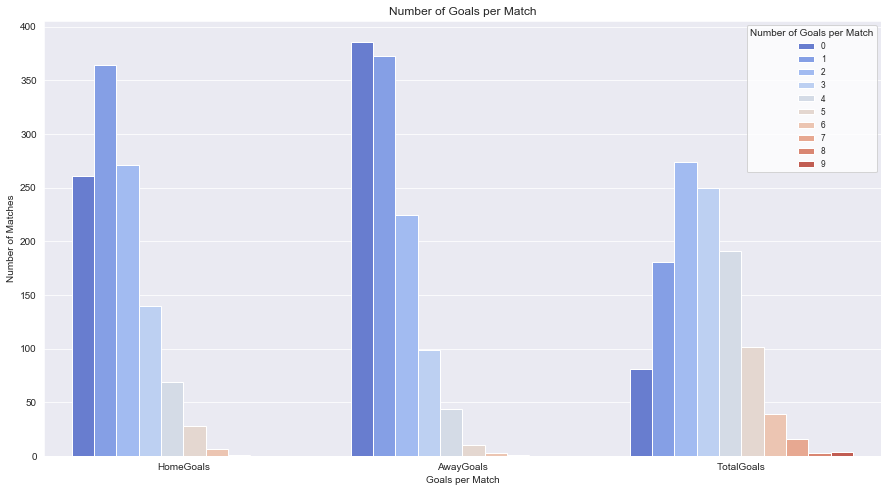

In [8]:
plt.figure(figsize=(15,8))
sns.set_style('darkgrid')
ax = sns.countplot(data=dfMelted,x='variable',hue='value', palette='coolwarm')
ax.set(xlabel='Goals per Match', ylabel='Number of Matches',title='Number of Goals per Match')
plt.legend(title="Number of Goals per Match", fontsize='small', fancybox=True,facecolor='white')

At this point, two potential distributions come to mind, purely due to the shape of the plots:

1) Lognormal Distribution (similar to a normal distribution, skewed to the right)

2) Poisson Distribution

**The Poisson Distribution makes more sense in this case, since we previously saw that means across the HomeGoals & AwayGoals classifications differed, and would thus have distributions that more accurately represent this. Moreover, the Poisson Distribution fits our problem pretty well, since it:**

1) Is a Discrete Probability Distribution, and there are a discrete number of goals to be scored in a match

2) Predicts probabilities within a specific time period, which, in this case, is a 90 minute game of football

3) Assumes events are independent of time (i.e. the probability of a goal being scored is not dependent on whether or not goals have already been scored in the match)

The formula for the Poisson Distribution is as follows:


$$P(x) = \frac{e^{-\lambda} \lambda^{x}}{x!}, \lambda > 0$$
Where $ \lambda = $ Average  Number  of  Goals

To test this, let's compare the distribution of TotalGoals with a Poisson Distribution:

In [9]:
_lambdaTotal = np.mean(df['TotalGoals'])
_lambdaAway = np.mean(df['AwayGoals'])
_lambdaHome = np.mean(df['HomeGoals'])

In [10]:
poisson_pmf = pd.DataFrame({'Goals':range(max(df['TotalGoals'])),
                            'Poisson Probability - Home':np.zeros(max(df['TotalGoals'])),
                            'Poisson Probability - Away':np.zeros(max(df['TotalGoals'])),
                            'Poisson Probability - Total':np.zeros(max(df['TotalGoals'])),
                           })
poisson_pmf

,Goals,Poisson Probability - Home,Poisson Probability - Away,Poisson Probability - Total
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
5,5,0.0,0.0,0.0
6,6,0.0,0.0,0.0
7,7,0.0,0.0,0.0
8,8,0.0,0.0,0.0


In [11]:
import math

for i in range(max(poisson_pmf['Goals'])):
    poisson_pmf['Poisson Probability - Home'][i] = (math.exp(-_lambdaHome)*_lambdaHome**(i)/math.factorial(i))
    poisson_pmf['Poisson Probability - Away'][i] = (math.exp(-_lambdaAway)*_lambdaAway**(i)/math.factorial(i))
    poisson_pmf['Poisson Probability - Total'][i] = (math.exp(-_lambdaTotal)*_lambdaTotal**(i)/math.factorial(i))
poisson_pmf

,Goals,Poisson Probability - Home,Poisson Probability - Away,Poisson Probability - Total
0,0,0.208923,0.300930,0.062871
1,1,0.327129,0.361380,0.173944
2,2,0.256108,0.216987,0.240622
3,3,0.133670,0.086858,0.221907
4,4,0.052325,0.026076,0.153486
5,5,0.016386,0.006263,0.084929
6,6,0.004276,0.001254,0.039162
7,7,0.000957,0.000215,0.015478
8,8,0.000000,0.000000,0.000000


In [12]:
poisson_pmf['Observed Probability - Home'] = np.zeros(9)
poisson_pmf['Observed Probability - Away'] = np.zeros(9)
poisson_pmf['Observed Probability - Total'] = np.zeros(9)

In [13]:
for i in poisson_pmf['Goals']:
    poisson_pmf['Observed Probability - Home'][i] = df['HomeGoals'][df['HomeGoals']==i].count()/df['HomeGoals'].count()
    poisson_pmf['Observed Probability - Away'][i] = df['AwayGoals'][df['AwayGoals']==i].count()/df['AwayGoals'].count()
    poisson_pmf['Observed Probability - Total'][i] = df['TotalGoals'][df['TotalGoals']==i].count()/df['TotalGoals'].count()
poisson_pmf

,Goals,Poisson Probability - Home,Poisson Probability - Away,Poisson Probability - Total,Observed Probability - Home,Observed Probability - Away,Observed Probability - Total
0,0,0.208923,0.300930,0.062871,0.228947,0.338596,0.071053
1,1,0.327129,0.361380,0.173944,0.319298,0.327193,0.158772
2,2,0.256108,0.216987,0.240622,0.237719,0.196491,0.240351
3,3,0.133670,0.086858,0.221907,0.122807,0.086842,0.219298
4,4,0.052325,0.026076,0.153486,0.060526,0.038596,0.167544
5,5,0.016386,0.006263,0.084929,0.024561,0.008772,0.088596
6,6,0.004276,0.001254,0.039162,0.005263,0.002632,0.034211
7,7,0.000957,0.000215,0.015478,0.000877,0.000877,0.014035
8,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.002632


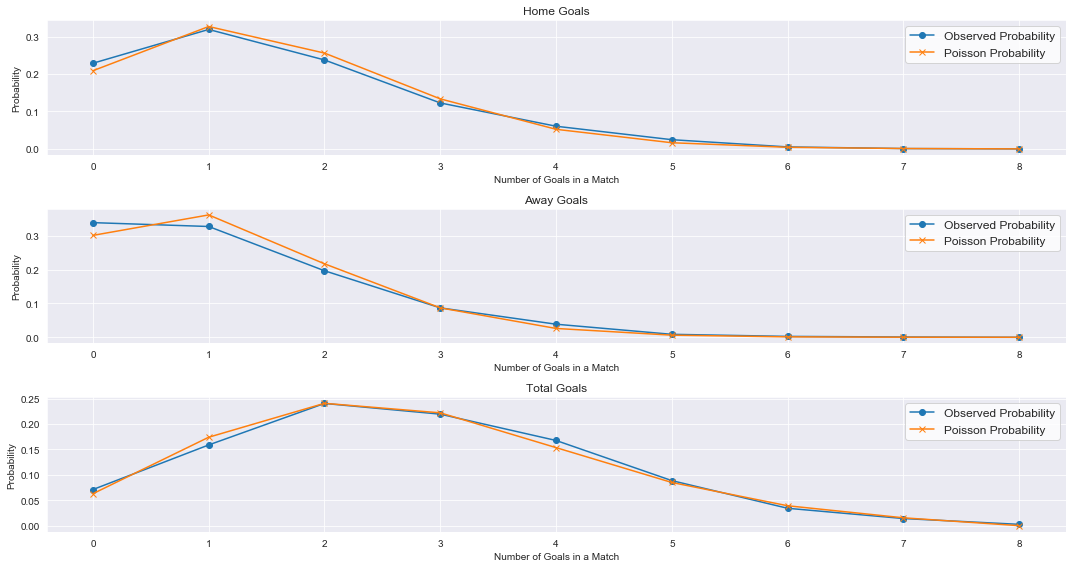

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(15,8))
sns.set_style('darkgrid')

axes[0].plot(poisson_pmf['Goals'],poisson_pmf['Observed Probability - Home'], label = 'Observed Probability', marker='o')
axes[0].plot(poisson_pmf['Goals'],poisson_pmf['Poisson Probability - Home'], label = 'Poisson Probability', marker = 'x')
axes[0].set_title('Home Goals')
axes[0].legend(fontsize='large', fancybox=True,facecolor='white')
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Number of Goals in a Match')

axes[1].plot(poisson_pmf['Goals'],poisson_pmf['Observed Probability - Away'], label = 'Observed Probability', marker = 'o')
axes[1].plot(poisson_pmf['Goals'],poisson_pmf['Poisson Probability - Away'], label = 'Poisson Probability', marker = 'x')
axes[1].set_title('Away Goals')
axes[1].legend(fontsize='large', fancybox=True,facecolor='white')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Number of Goals in a Match')

axes[2].plot(poisson_pmf['Goals'],poisson_pmf['Observed Probability - Total'], label = 'Observed Probability', marker = 'o')
axes[2].plot(poisson_pmf['Goals'],poisson_pmf['Poisson Probability - Total'], label = 'Poisson Probability', marker = 'x')
axes[2].set_title('Total Goals')
axes[2].legend(fontsize='large', fancybox=True,facecolor='white')
axes[2].set_ylabel('Probability')
axes[2].set_xlabel('Number of Goals in a Match')

plt.tight_layout()

As we can see, the Poisson distribution aligns decently well with the observed distribution regarding the number of goals scored in a match. That's a good sign!

For further confirmation, let's take a look at the Skellam distribution, which represents a difference between two Poisson-Distributed variables. In this case, we'll take a look at the difference between HomeGoals and AwayGoals

In [15]:
from scipy.stats import skellam

In [16]:
# Set up a dataframe with values of "Difference", the difference of goals between the home team and away team,
# from -10 to 10, just to be sure we encompass all possible values

values = []
values.extend(range(-10,11))
skellamdf = pd.DataFrame(columns=["Difference","Skellam"])
skellamdf.Difference = values
skellamdf.head()

,Difference,Skellam
0,-10,NaN
1,-9,NaN
2,-8,NaN
3,-7,NaN
4,-6,NaN


In [17]:
pmf_temp = []
for i in skellamdf['Difference']:
    pmf_temp.append(skellam.pmf(i,  df.mean()[0],  df.mean()[1]))
skellamdf['Skellam'] = pmf_temp

In [18]:
df['Difference'] = df['HomeGoals'] - df['AwayGoals']
df.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,TotalGoals,Difference
0,Man United,Leicester,2,1,3,1
1,Bournemouth,Cardiff,2,0,2,2
2,Fulham,Crystal Palace,0,2,2,-2
3,Huddersfield,Chelsea,0,3,3,-3
4,Newcastle,Tottenham,1,2,3,-1


In [19]:
# Create a distribution

differenceDistribution = []

for i in skellamdf['Difference']:
    differenceDistribution.append(df['Difference'][df['Difference']==i].count()/df['Difference'].count())

In [20]:
skellamdf['Observed'] = differenceDistribution

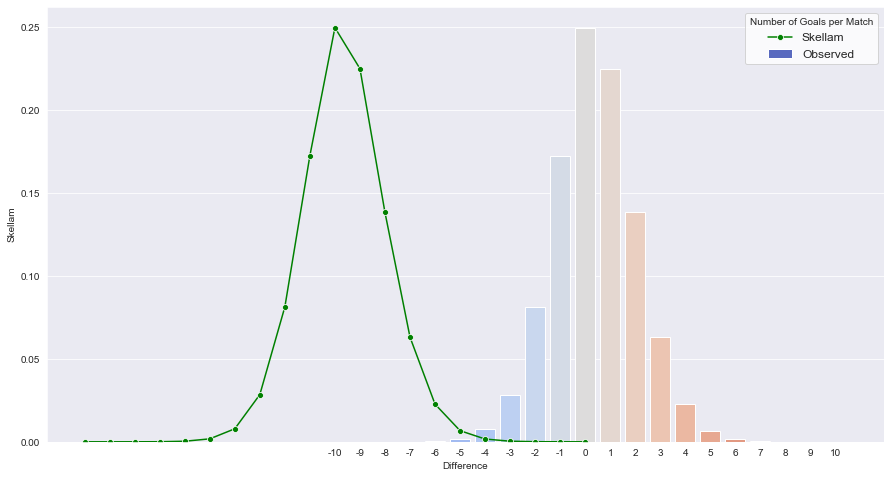

In [21]:
# Skellam vs Actual

plt.figure(figsize=(15,8))
sns.set_style('darkgrid')
sns.barplot(data=skellamdf,x=skellamdf['Difference'], y='Skellam', palette='coolwarm', label = 'Observed')
sns.lineplot(data=skellamdf,x=skellamdf['Difference'], y='Skellam', label = 'Skellam', marker='o', color='green')
plt.legend(title="Number of Goals per Match", fontsize='large', fancybox=True,facecolor='white')

Again, we see a pretty good match here! The skellam distribution mimics the observed distribution of the difference in goals between the home team and the away team. We can see that it is almost impossible for the home team to win by more than 6 goals or lose by more than 5 goals, with the most likely difference being 0, indicating a draw. However, there seems to be a higher probability for the home team winning, which is consistent with what we have seen previously.

# Creating the Poisson Distribution Model

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [23]:
goal_model_data = pd.concat([df[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           df[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2280
Model:                            GLM   Df Residuals:                     2228
Model Family:                 Poisson   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3229.2
Date:                Sun, 12 Jan 2020   Deviance:                       2433.8
Time:                        19:56:24   Pearson chi2:                 2.10e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.4798      0.110      4.364      0.000       0.264       0.695
team[T.Bournemouth]           -0.3454      0.104     -3.306      0.001      -0.550      -0.141
team[T.Brighton]              -0.7580      0.138     -5.496      0.000      -1.028      -0.488
team[T.Burnley]               -0.6206      0.113     -5.478      0.000      -0.843      -0.399
team[T.Cardiff]               -0.7688      0.184     -4.168      0.000      -1.130      -0.407
team[T.Chelsea]               -0.0770      0.096     -0.800      0.424      -0.266       0.112
team[T.Crystal Palace]        -0.4210      0.107     -3.951      0.000      -0.630      -0.212
team[T.Everton]               -0.3369      0.104     -3.249      0.001      -0.540      -0.134
team[T.Fulham]                -0.7568      0.184     -4.102      0.000      -1.118      -0.395
team[T.Huddersfield]          -1.0707      0.157     -6.836      0.000      -1.378      -0.764
team[T.Hull]                  -0.6882      0.178     -3.869      0.000      -1.037      -0.340
team[T.Leicester]             -0.3610      0.105     -3.449      0.001      -0.566      -0.156
team[T.Liverpool]              0.0992      0.092      1.077      0.281      -0.081       0.280
team[T.Man City]               0.2080      0.090      2.318      0.020       0.032       0.384
team[T.Man United]            -0.1929      0.099     -1.945      0.052      -0.387       0.002
team[T.Middlesbrough]         -1.0307      0.204     -5.050      0.000      -1.431      -0.631
team[T.Newcastle]             -0.6068      0.130     -4.671      0.000      -0.861      -0.352
team[T.Southampton]           -0.5935      0.112     -5.281      0.000      -0.814      -0.373
team[T.Stoke]                 -0.6638      0.133     -4.991      0.000      -0.925      -0.403
team[T.Sunderland]            -0.9434      0.198     -4.771      0.000      -1.331      -0.556
team[T.Swansea]               -0.7032      0.135     -5.208      0.000      -0.968      -0.439
team[T.Tottenham]             -0.0019      0.094     -0.021      0.984      -0.187       0.183
team[T.Watford]               -0.4854      0.109     -4.458      0.000      -0.699      -0.272
team[T.West Brom]             -0.6990      0.134     -5.204      0.000      -0.962      -0.436
team[T.West Ham]              -0.4087      0.106     -3.844      0.000      -0.617      -0.200
team[T.Wolves]                -0.4672      0.161     -2.903      0.004      -0.783      -0.152
opponent[T.Bournemouth]        0.2826      0.109      2.586      0.010       0.068       0.497
opponent[T.Brighton]           0.1149      0.125      0.918      0.359      -0.130       0.360
opponent[T.Burnley]            0.0692      0.114      0.606      0.545      -0.155       0.293
opponent[T.Cardiff]            0.3037      

This produces an output similar to a regression, where a positive "coef" would mean more expected goals and a negative "coef" would mean less goals, and values closer to 0 would indicate more neutral effects in comparison to the intercept.

For example, Man City have a positive coefficient equal to 0.2080, meaning they would generally score more goals than an average team. Moreover, we see that Man City's **opponent value** is negative at -0.4771. The opponent value penalizes or rewards teams based on the value of the opposition. Man City's negative coefficient indicates that it is harder to score against them than the average opponent, while a positive coefficient would mean that it is generally easier to score against that opponent. 

Now, let's try predicting a match between Chelsea and Man City. To do so, I will create the predict_match function.

Within this function, I will be specifying 4 variables:

1) foot_model: The type of statistical model being used to model the data. In this case, we'll have the 'poisson_model'

2) homeTeam: A string value containing the desired home team name.

3) awayTeam: A string value containing the desired away team name.

4) max_goals: The maximum number of goals allowed in the game, as a sum of homeTeam and awayTeam goals. I set this to 10.

In [24]:
def predict_match(foot_model, homeTeam, awayTeam, max_goals=10):
    from scipy.stats import poisson
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

Now, let's simulate that match between Chelsea and Man City:

In [25]:
chelsea_city = predict_match(poisson_model, 'Chelsea', 'Man City',max_goals=3)
chelsea_city

array([[0.06715664, 0.10008115, 0.07457369, 0.03704484],
       [0.08129063, 0.12114453, 0.0902687 , 0.04484141],
       [0.04919965, 0.0733205 , 0.05463346, 0.02713944],
       [0.01985146, 0.02958392, 0.02204393, 0.01095043]])

This outputted array shows us the probability of each team scoring a certain amount of goals. In this case, Chelsea's number of goals are represented by rows, and Man City's number of goals are represented by columns. For example:

- The first array entry at [0,0], 0.06715664, shows us the probability of Chelsea scoring 0 goals, and Man City scoring 0 goals.

- The entry at [0,1], 0.10008115, shows us the probability of Chelsea scoring 0 goals, and Man City scoring 1 goal.

- The entry at [2,1], 0.0733205, shows us the probability of Chelsea scoring 2 goals, and Man City scoring 1 goal.

... And so on

Now, let's calculate the probability of Chelsea winning. On the array, the event of Chelsea winning would be indicated by any entry on the lower triangle of the square array. The event of Man City winning would be indicated by any entry on the upper triangle. The event of a draw is represented by the diagonal entries of the array.

In [26]:
# For the model to completely work, we would need to assume max_goals = 10, as to encompass all possible outcomes
chelsea_city = predict_match(poisson_model, 'Chelsea', 'Man City')

In [27]:
np.sum(chelsea_city)

0.999999414005042

In [28]:
chelsea_prob = np.sum(np.tril(chelsea_city,-1))

city_prob = np.sum(np.triu(chelsea_city,1))

draw_prob = np.sum(np.diag(chelsea_city))

print('''Based off of our data, in a match of Chelsea vs. Man City at home:\n\nThe probability of Chelsea winning is %f
The probability of Man City winning is %f\nThe probability of a draw is %f''' %(chelsea_prob,city_prob,draw_prob))

Based off of our data, in a match of Chelsea vs. Man City at home:

The probability of Chelsea winning is 0.308133
The probability of Man City winning is 0.436653
The probability of a draw is 0.255213


And the actual result of the game in the 2018/19 was...

In [29]:
chelsea_goals = epl_1819[(epl_1819['HomeTeam']=='Chelsea')&(epl_1819['AwayTeam']=='Man City')]['FTHG']

city_goals = epl_1819[(epl_1819['HomeTeam']=='Chelsea')&(epl_1819['AwayTeam']=='Man City')]['FTAG']

print("Chelsea %d - %d Man City" %(chelsea_goals,city_goals))

Chelsea 2 - 0 Man City


As we can see, reality weighed in favor of Chelsea, instead of the predicted Man City win. The football world is riddled with surprises and upsets. However, the probabilities do make logical sense, as, in the 2018-19 season, Man City ended up winning the league with 98 points, and Chelsea ended up in 3rd place with only 72 points, indicating Man City were a much better team during the season, which is exactly what the probabilities are telling us too!

To test this result, we'd need to compare it with a betting company's odds, which we have handy!

In [30]:
bet365odds = epl_1819[(epl_1819['HomeTeam']=='Chelsea')&(epl_1819['AwayTeam']=='Man City')][['B365H','B365D','B365A']]
bet365odds = bet365odds.rename(columns={'B365H':'Chelsea Win','B365D':'Draw','B365A':'Man City Win'})
bet365odds

,Chelsea Win,Draw,Man City Win
154,4.0,3.8,1.95


Now to convert these odds into probabilities, using the following formula: 

$$Probability = \frac{1}{Decimal Odds}$$

In [31]:
bet365odds['Chelsea Win'] = 1/bet365odds['Chelsea Win']
bet365odds['Man City Win'] = 1/bet365odds['Man City Win']
bet365odds['Draw'] = 1/bet365odds['Draw']
bet365odds

,Chelsea Win,Draw,Man City Win
154,0.25,0.263158,0.512821


In [32]:
model_prob = pd.DataFrame.from_dict({'Chelsea Win': [chelsea_prob], 'Draw': [draw_prob], 'Man City Win': [city_prob]})
model_prob

,Chelsea Win,Draw,Man City Win
0,0.308133,0.255213,0.436653


In [33]:
bet365odds = bet365odds.append(model_prob).reset_index().rename(columns={'index':'Source'})
bet365odds['Source'] = ['Bet 365','Our Model']
bet365odds = bet365odds.set_index('Source')
bet365odds

,Chelsea Win,Draw,Man City Win
Source,,,
Bet 365,0.250000,0.263158,0.512821
Our Model,0.308133,0.255213,0.436653


The differences between Bet 365's probabilities and our probabilities are as follows:

In [34]:
bet365odds.diff(axis=0).loc['Our Model']

Chelsea Win     0.058133
Draw           -0.007945
Man City Win   -0.076168
Name: Our Model, dtype: float64

# Evaluating Our Model

As we can see, we weren't too far off with our calculations. We somewhat underestimated the probability of a Man City win, and that's fine! That's because Man City progressively became a better and better team with years gone by due to extensive purchases of great players, a great manager, increased team chemistry, and more! The more the data is weighted towards more recent results, the more accurate our model becomes! This indicates that sometimes, less data might indeed be better, due to the changes that happen from season to season within the sport.

Moreover, as previously mentioned, the Poisson Distribution may oversimplify things. There are plenty of factors that could be taken into consideration, such as:

1) The expected starting lineups of each side (i.e. Are certain players injured? Will the manager decide to start his best team?)

2) Form (i.e. Assigning more weight to more recent results)

3) How far along into the season are we? What does the team have to play for? Are they competing for the title, or will a win make no difference whatsoever? (i.e. Motivation)

4) Historical Results between the two teams (Even if Man City are the better team now, do Chelsea have a good track record against them? Maybe Chelsea have a playing style that combats Man City's very well)

5) Inability to weight data towards more recent results reasonably. Here, we could potentially use a weighted mean with higher weights on more recent results, but it wouldn't reflect the entire story.

And many more!